In [1]:
from tqdm import tqdm
import pandas as pd
import jsonlines
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
import plotly.express as px
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import cohen_kappa_score
from scipy import stats
import os


## General Functions to Read Documents

In [2]:
def read_jsonl(file):
    results = []
    with jsonlines.open(file) as reader:
        for obj in reader:
            results.append(obj)
    return results

In [3]:
# read main tournament results on 17 models

judge_debate_rounds = 1
tournament_dir = 'data/main_tour_40'
rounds = [r for r in os.listdir(tournament_dir) if 'round' in r]

judge_files = []
for r in rounds:
    judge_files += [f'{tournament_dir}/{r}/{f}' for f in os.listdir(f'{tournament_dir}/{r}') if f.endswith('_judge_results.jsonl')]

judge_results = []
for j in judge_files:
    judge_results.extend(list(read_jsonl(j)))
print(f'loaded {len(judge_results)} judge results')
judge_results = [j for j in judge_results if j['judge_debate_rounds'] == judge_debate_rounds]
print(f'filtered to {len(judge_results)} judge results')

loaded 2160 judge results
filtered to 2160 judge results


In [4]:
# Show all judgements as a dataframe

model_a = [j['gamekey'][1] for j in judge_results]
model_b = [j['gamekey'][2] for j in judge_results]
winner = [j['final_winner'][judge_debate_rounds] for j in judge_results]
df = pd.DataFrame({'model_a': model_a, 'model_b': model_b, 'winner': winner})
df = df[df['winner'] != 'tie']
df.head()

,model_a,model_b,winner
1,gpt-4-turbo-2024-04-09,meta-llama/Llama-3-70b-chat-hf,A
2,gpt-4-turbo-2024-04-09,meta-llama/Llama-3-70b-chat-hf,A
3,meta-llama/Llama-3-70b-chat-hf,gpt-4-turbo-2024-04-09,A
4,meta-llama/Llama-3-70b-chat-hf,gpt-4-turbo-2024-04-09,A
5,meta-llama/Llama-3-70b-chat-hf,gpt-4-turbo-2024-04-09,A


## ELO Computation

In [5]:
# This is the same function as in Chatbot Arena: https://colab.research.google.com/drive/1KdwokPjirkTmpO_P1WByFNFiqxWQquwH
# maxmium likelihood estimation for elo score
def compute_mle_elo(df, SCALE=400, BASE=10, INIT_RATING=1000):
    models = pd.concat([df["model_a"], df["model_b"]]).unique()
    models = pd.Series(np.arange(len(models)), index=models)

    # duplicate battles
    df = pd.concat([df, df], ignore_index=True)
    p = len(models.index)
    n = df.shape[0]

    X = np.zeros([n, p])
    X[np.arange(n), models[df["model_a"]]] = +math.log(BASE)
    X[np.arange(n), models[df["model_b"]]] = -math.log(BASE)

    # one A win => two A win
    Y = np.zeros(n)
    Y[df["winner"] == "A"] = 1.0

    # one tie => one A win + one B win
    # find tie + tie (both bad) index
    tie_idx = (df["winner"] == "tie")
    tie_idx[len(tie_idx)//2:] = False
    Y[tie_idx] = 1.0

    lr = LogisticRegression(fit_intercept=False, penalty=None, tol=1e-8)
    lr.fit(X,Y)

    elo_scores = SCALE * lr.coef_[0] + INIT_RATING

    # set anchor as mixtral = 1000
    if "Mixtral-8x7B-Instruct-v0.1" in models.index:
        elo_scores += 1000 - elo_scores[models["mixtral-8x7b-instruct-v0.1"]]
    return pd.Series(elo_scores, index = models.index).sort_values(ascending=False)

In [6]:
# This is the same function as in Chatbot Arena: https://colab.research.google.com/drive/1KdwokPjirkTmpO_P1WByFNFiqxWQquwH
# print ELO score results
def preety_print_model_ratings(ratings):
    df = pd.DataFrame([
        [n, ratings[n]] for n in ratings.keys()
    ], columns=["Model", "Elo rating"]).sort_values("Elo rating", ascending=False).reset_index(drop=True)
    # df["Elo rating"] = (df["Elo rating"] + 0.5).astype(int)
    df.index = df.index + 1
    return df

In [7]:
# ELOs of all 17 models
elo_mle_ratings = compute_mle_elo(df)
preety_print_model_ratings(elo_mle_ratings)

,Model,Elo rating
1,gpt-4o-2024-05-13,1216.523667
2,gpt-4-turbo-2024-04-09,1150.202139
3,minimax-abab6.5-chat,1096.749579
4,meta-llama/Llama-3-70b-chat-hf,1082.036858
5,glm-4,1070.157148
6,command-r-plus,1053.089034
7,reka-core-20240501,1029.782494
8,claude-3-haiku-20240307,1028.581414
9,Qwen/Qwen1.5-72B-Chat,1026.452861
10,SenseChat-5,1007.193560


## Calculation of Agreement Among Judges

In [8]:
# read main tournament results on 7 models

judge_debate_rounds = 1
tournament_dir = 'data/main_tour_40'
rounds = [r for r in os.listdir(tournament_dir) if 'round' in r and 'add' not in r]

judge_files = []
for r in rounds:
    judge_files += [f'{tournament_dir}/{r}/{f}' for f in os.listdir(f'{tournament_dir}/{r}') if f.endswith('_judge_results.jsonl')]

judge_results_7_models = []
for j in judge_files:
    judge_results_7_models.extend(list(read_jsonl(j)))
print(f'loaded {len(judge_results_7_models)} judge results')
judge_results_7_models = [j for j in judge_results_7_models if j['judge_debate_rounds'] == judge_debate_rounds]
print(f'filtered to {len(judge_results_7_models)} judge results')

loaded 360 judge results
filtered to 360 judge results


In [9]:
# probability of two models agreeing (like MT-Bench)
def judge_agreement(judge_results, judge_debate_rounds, judges):
    pairings = [(a, b) for idx, a in enumerate(judges) for b in judges[idx + 1:]]
    agreements = []
    for (a, b) in pairings:
        agree = 0
        total = 0
        for eval in judge_results:
            # exclude error
            if a in eval['judges'] and b in eval['judges'] and eval[a]['winner'][judge_debate_rounds] != 'error' and eval[b]['winner'][judge_debate_rounds] != 'error':
                total += 1
                # count ties
                if eval[a]['winner'][judge_debate_rounds] == eval[b]['winner'][judge_debate_rounds]:
                    agree += 1
        agreements.append(agree / total)
    print(f"Probability of two judges agreeing: {np.mean(agreements)}")

In [10]:
judges = ['gpt-4-turbo-2024-04-09', 'Qwen/Qwen1.5-72B-Chat', 'claude-3-haiku-20240307',
                    'zero-one-ai/Yi-34B-Chat', 'mistralai/Mixtral-8x7B-Instruct-v0.1', 'gpt-35-turbo-0125',
                    'meta-llama/Llama-2-70b-chat-hf']
print('Agreement before discussion:')
judge_agreement(judge_results_7_models, 0, judges)
print('Agreement after discussion:')
judge_agreement(judge_results_7_models, 1, judges)

Agreement before discussion:
Probability of two judges agreeing: 0.47833725304992275
Agreement after discussion:
Probability of two judges agreeing: 0.6799701878450359


In [11]:
# Cohen's Kappa agreement (Average)
def calculate_cohen_kappa(j1, j2, judge_results, judge_debate_rounds):
    rater_1 = []
    rater_2 = []
    for eval in judge_results:
        if j1 in eval['judges'] and j2 in eval['judges'] and eval[j1]['winner'][judge_debate_rounds] != 'error' and eval[j2]['winner'][judge_debate_rounds] != 'error':
           rater_1.append(eval[j1]['winner'][judge_debate_rounds])
           rater_2.append(eval[j2]['winner'][judge_debate_rounds])
    return cohen_kappa_score(rater_1, rater_2)

def calculate_tournament_cohens_kappa(judges, judge_results, judge_debate_rounds):
    all_cohen_kappas = []
    already_evaled_pairs = []
    data = np.zeros((len(judges), len(judges)))
    for i_1, j_1 in enumerate(judges):
        for i_2, j_2 in enumerate(judges):
            data[i_1][i_2] = calculate_cohen_kappa(j_1, j_2, judge_results, judge_debate_rounds)
            if (j_1, j_2) not in already_evaled_pairs and (j_2, j_1) not in already_evaled_pairs and j_1 != j_2:
                already_evaled_pairs.append((j_1, j_2))
                all_cohen_kappas.append(data[i_1][i_2])
    print(f"Average Cohen Kappa: {np.mean(all_cohen_kappas)}")
    return data

In [12]:
print('Before Discussion: ')
data_before = calculate_tournament_cohens_kappa(judges, judge_results_7_models, 0)
print('After Discussion: ')
data_after = calculate_tournament_cohens_kappa(judges, judge_results_7_models, 1)

Before Discussion: 
Average Cohen Kappa: 0.1151201181755366
After Discussion: 
Average Cohen Kappa: 0.37696633483222153


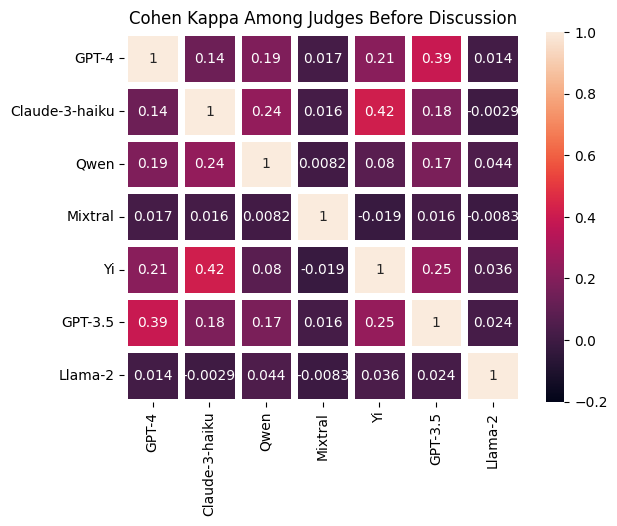

In [13]:
# Plot Cohen's Kappa agreement

judge_names = ['GPT-4', 'Claude-3-haiku', 'Qwen', 'Mixtral','Yi', 'GPT-3.5', 'Llama-2']

sns.heatmap(
    data_before, 
    # mask=np.tri(len(judges)),
    annot=True, linewidths=5,
    vmin=-0.2, vmax=1,
    xticklabels=judge_names,
    yticklabels=judge_names,
)
plt.title('Cohen Kappa Among Judges Before Discussion')
plt.show()

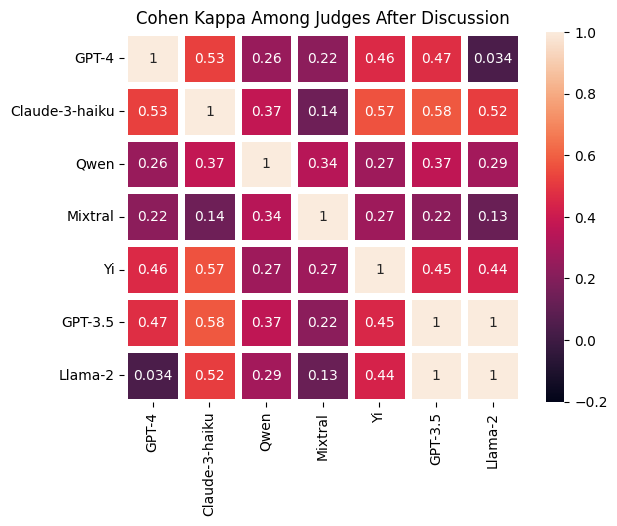

In [14]:
# Plot Cohen's Kappa agreement
sns.heatmap(
    data_after, 
    # mask=np.tri(len(judges)),
    annot=True, linewidths=5,
    vmin=-0.2, vmax=1,
    xticklabels=judge_names,
    yticklabels=judge_names,
)
plt.title('Cohen Kappa Among Judges After Discussion')
plt.show()

#### Calculation of agreement between each judge and the majority vote results

In [15]:
def calculate_majority_vote_cohen_kappa(j1, judge_results, judge_debate_rounds):
    rater_1 = []
    majority_vote = []
    for eval in judge_results:
        if j1 in eval['judges'] and eval[j1]['winner'][judge_debate_rounds] != 'error':
           rater_1.append(eval[j1]['winner'][judge_debate_rounds])
           majority_vote.append(eval['final_winner'][judge_debate_rounds])
    return cohen_kappa_score(rater_1, majority_vote)

Average Cohen Kappa: 0.36187845934066803


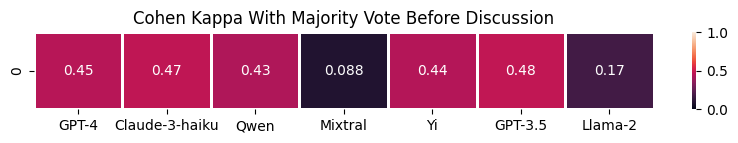

In [16]:
data = np.zeros(len(judges))
for i_1, j_1 in enumerate(judges):
        data[i_1] = calculate_majority_vote_cohen_kappa(j_1, judge_results_7_models, 0)
print(f"Average Cohen Kappa: {np.mean(data)}")

data = data.reshape(-1, 1).transpose()
judge_names = ['GPT-4', 'Claude-3-haiku', 'Qwen', 'Mixtral','Yi', 'GPT-3.5', 'Llama-2']
fig, ax = plt.subplots(figsize=(10,1))  
sns.heatmap(
    data, 
    # mask=np.tri(len(judges)),
    annot=True, linewidths=1,
    vmin=0, vmax=1,
    xticklabels=judge_names,
)
plt.title('Cohen Kappa With Majority Vote Before Discussion')
plt.show()

Average Cohen Kappa: 0.5580377858148767


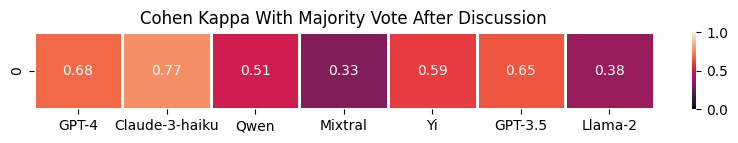

In [17]:
data = np.zeros(len(judges))
for i_1, j_1 in enumerate(judges):
        data[i_1] = calculate_majority_vote_cohen_kappa(j_1, judge_results_7_models, 1)
print(f"Average Cohen Kappa: {np.mean(data)}")

data = data.reshape(-1, 1).transpose()
judge_names = ['GPT-4', 'Claude-3-haiku', 'Qwen', 'Mixtral','Yi', 'GPT-3.5', 'Llama-2']
fig, ax = plt.subplots(figsize=(10,1))  
sns.heatmap(
    data, 
    # mask=np.tri(len(judges)),
    annot=True, linewidths=1,
    vmin=0, vmax=1,
    xticklabels=judge_names,
)
plt.title('Cohen Kappa With Majority Vote After Discussion')
plt.show()

## Ablation Study on the Effect of peer debate

In [18]:
# results with peer debate
judge_debate_rounds = 1
tournament_dir = 'data/main_tour_40'
rounds = [r for r in os.listdir(tournament_dir) if 'round' in r and '_add' not in r]

judge_files = []
for r in rounds:
    judge_files += [f'{tournament_dir}/{r}/{f}' for f in os.listdir(f'{tournament_dir}/{r}') if f.endswith('_judge_results.jsonl')]

judge_results = []
for j in judge_files:
    judge_results.extend(list(read_jsonl(j)))
print(f'loaded {len(judge_results)} judge results')
judge_results = [j for j in judge_results if j['judge_debate_rounds'] == judge_debate_rounds]
print(f'filtered to {len(judge_results)} judge results')

loaded 360 judge results
filtered to 360 judge results


In [19]:
# results without peer debate
judge_debate_rounds = 1
tournament_dir = 'data/tour_without_peer_debate'
rounds = [r for r in os.listdir(tournament_dir) if 'round' in r and '_add' not in r]

judge_files = []
for r in rounds:
    judge_files += [f'{tournament_dir}/{r}/{f}' for f in os.listdir(f'{tournament_dir}/{r}') if f.endswith('_judge_results.jsonl')]

judge_results_no_debate = []
for j in judge_files:
    judge_results_no_debate.extend(list(read_jsonl(j)))
print(f'loaded {len(judge_results_no_debate)} judge results')
judge_results_no_debate = [j for j in judge_results_no_debate if j['judge_debate_rounds'] == judge_debate_rounds]
print(f'filtered to {len(judge_results_no_debate)} judge results')

loaded 360 judge results
filtered to 360 judge results


## correlation analysis

In [22]:
# function to reorganize ELO results
import pandas as pd
import os

tournament = 'data/tour_without_peer_debate/'
rounds = [f for f in os.listdir(tournament) if 'round' in f]
reorg_head = ['gpt-4o-2024-05-13',
              'gpt-4-turbo-2024-04-09', 'minimax-abab6.5-chat','meta-llama/Llama-3-70b-chat-hf',	'glm-4', 
              'reka-core-20240501','command-r-plus',
              'claude-3-haiku-20240307',
            'Qwen/Qwen1.5-72B-Chat','SenseChat-5', 'qwen-max-0428',
            'mistralai/Mixtral-8x7B-Instruct-v0.1','wenxin-4','zero-one-ai/Yi-34B-Chat',
            'mistral-large-2402','gpt-35-turbo-0125','deepseek-ai/deepseek-llm-67b-chat',
            'meta-llama/Llama-2-70b-chat-hf']

for r in rounds:
  elo_history_file = f'data/main_tour_40/{r}/elo_history.csv'
  elo_df = pd.read_csv(elo_history_file)
  existing_head = elo_df.columns.tolist()
  new_one = [c for c in existing_head if c not in reorg_head and c != 'Unnamed: 0']
  reorg_elo_df = elo_df.reindex(columns=reorg_head + new_one)
  # save csv
  reorg_elo_df.to_csv(elo_history_file.replace('.csv', '_reorg.csv'), index=False)

In [23]:
from scipy import stats

# function to get correlation
def get_correlation(x, y):
    res = stats.spearmanr(x, y)
    print('spearman: ', res.statistic)
    res_p = stats.pearsonr(x, y)
    print('pearson: ', res_p[0])

In [24]:
# calculate Chatbot Arena ELOs
import pandas as pd
# read pickle
elos = pd.read_pickle('assets/arena_csv/elo_results_20240520.pkl')['english']['leaderboard_table_df']
# our models that are also on Chatbot Arena
our_models = ['gpt-4o-2024-05-13', 'gpt-4-turbo-2024-04-09', 'llama-3-70b-instruct', 'claude-3-haiku-20240307', \
              'qwen1.5-72b-chat', 'deepseek-llm-67b-chat', \
              'mixtral-8x7b-instruct-v0.1', 'yi-34b-chat', 'gpt-3.5-turbo-0125', 'llama-2-70b-chat']
# filter indices in our_models
elos = elos[elos.index.isin(our_models)]
# sort by 'rating' column
elos = elos.sort_values('rating', ascending=False)
elos

FileNotFoundError: [Errno 2] No such file or directory: 'assets/arena_csv/elo_results_20240520.pkl'

In [25]:
from collections import defaultdict
names_arena_to_ours = {'qwen1.5-72b-chat': 'Qwen/Qwen1.5-72B-Chat',
                       'mixtral-8x7b-instruct-v0.1': 'mistralai/Mixtral-8x7B-Instruct-v0.1',
                       'yi-34b-chat': 'zero-one-ai/Yi-34B-Chat',
                        'gpt-3.5-turbo-0125': 'gpt-35-turbo-0125',
                        'llama-2-70b-chat': 'meta-llama/Llama-2-70b-chat-hf'}
def get_elos_from_file(our_models, file):
    elos = pd.read_csv(file)
    results = []
    for model in our_models:
        if model in names_arena_to_ours:
            model = names_arena_to_ours[model]
        # if model in columns
        if model in elos.columns:
            results.append(elos[model].values[-1])
        else:
            print(f'{model} not in columns')
            results.append('na')
    return results

In [27]:
# Correlation on the first 7 models

# arena names
our_models = ['gpt-4-turbo-2024-04-09', 'claude-3-haiku-20240307', 'qwen1.5-72b-chat', \
              'mixtral-8x7b-instruct-v0.1', 'yi-34b-chat', 'gpt-3.5-turbo-0125', 'llama-2-70b-chat']

# arena elos
elos = pd.read_pickle('data/elo_results_20240527.pkl')['english']
arena_elo = [elos['elo_rating_final'][m] for m in our_models]

# our elos
our_elo = get_elos_from_file(our_models, 'data/main_tour_40/round3/elo_history.csv')
no_debate_elo = get_elos_from_file(our_models, 'data/tour_without_peer_debate/round3/elo_history.csv')
mmlu = [86.5,	75.2,	77.2,	71.4,	74.87,	70,	63.91]
openllm = [86.27,	84.8,	72.91,	72.71,	63.17,	71.02,	62.4]
mtbench_hard = [82.6,	41.5,	36.1,	23.4,	23.1,	23.3,	11.6]
mtbench = ['na', 9.1,	8.62,	8.3,	7.9,	7.94,	6.86]
alpacaeval = [55, 'na',		36.60,	23.70,	27.20, 'na',		14.70]
print('--------ours--------')
get_correlation(arena_elo, our_elo)
print('--------no_debate--------')
get_correlation(arena_elo, no_debate_elo)
print('--------mmlu--------')
get_correlation(arena_elo, mmlu)
print('--------openllm--------')
get_correlation(arena_elo, openllm)
print('--------mtbench_hard--------')
get_correlation(arena_elo, mtbench_hard)
print('--------mtbench--------')
get_correlation([arena_elo[i] for i in range(len(arena_elo)) if mtbench[i] != 'na'], [mtbench[i] for i in range(len(arena_elo)) if mtbench[i] != 'na'])
print('--------alpacaeval--------')
get_correlation([arena_elo[i] for i in range(len(arena_elo)) if alpacaeval[i] != 'na'], [alpacaeval[i] for i in range(len(arena_elo)) if alpacaeval[i] != 'na'])

--------ours--------
spearman:  0.9642857142857145
pearson:  0.8919563063697554
--------no_debate--------
spearman:  0.5
pearson:  0.4333669054754603
--------mmlu--------
spearman:  0.8928571428571429
pearson:  0.8834042795089067
--------openllm--------
spearman:  0.8928571428571429
pearson:  0.8255167892360826
--------mtbench_hard--------
spearman:  0.8928571428571429
pearson:  0.973364118521209
--------mtbench--------
spearman:  0.8285714285714287
pearson:  0.8060072104570984
--------alpacaeval--------
spearman:  0.8999999999999998
pearson:  0.9481431414689903


In [28]:
# On the 17 models


ours = [1197.260,	1137.712,	1090.027116,	1076.688,	1063.642,	1027.868,	1048.063,	1025.715,	1024.823,	1007.460,	963.534,	955.096,	942.011,	926.585,	890.189,	841.463,	815.808]

# dedup english only
arena = [1274.25,	1243.6,	'na',	1228.61,	'na',	1182.67,	1162.19,	1158.48,	1136.49,	'na',	1114,	'na',	1106.98,	1146.69,	1083.18,	1064.71,	1096.13]

mmlu = [87.2,	86.5,	78.7,	80.06,	81.5,	83.2,	75.7,	75.2,	77.2,	84.7,	71.4,	'na',	74.87,	81.2,	70,	71.3,	63.91]
openllm = ['na',	86.27,	'na',	77.88,	'na',	'na',	74.62,	84.8,	72.91,	'na',	'na',	'na',	63.17,	'na',	71.02,	'na',	62.4]
mtb_h = ['na',	82.6,	'na',	41.1,	'na',	'na',	33.1,	41.5,	36.1,	'na',	23.4,	'na',	23.1,	37.7,	23.3,	'na',	11.6]
lc_a = [57.5,	55,	'na',	34.4,	'na',	'na',	'na',	'na',	36.6,	'na',	23.7,	'na',	27.2,	32.7,	17.7,	17.8,	14.7]
mtb = ['na',	'na',	'na',	'na',	'na',	'na',	'na',	9.1,	8.61,	'na',	8.3,	'na',	7,	8.63,	7.94,	'na',	6.86]
print('--------------ours to arena--------------')
ours_new = [ours[i] for i in range(len(ours)) if arena[i] != 'na']
arena_new = [arena[i] for i in range(len(arena)) if arena[i] != 'na']
get_correlation(ours_new, arena_new)

print('--------------mmlu to arena--------------')
indices = [i for i in range(len(mmlu)) if arena[i] != 'na' and mmlu[i] != 'na']
get_correlation([mmlu[i] for i in indices], [arena[i] for i in indices])

print('--------------openllm to arena--------------')
indices = [i for i in range(len(openllm)) if arena[i] != 'na' and openllm[i] != 'na']
get_correlation([openllm[i] for i in indices], [arena[i] for i in indices])

print('--------------mtbench to arena--------------')
indices = [i for i in range(len(mtb)) if arena[i] != 'na' and mtb[i] != 'na']
get_correlation([mtb[i] for i in indices], [arena[i] for i in indices])

print('--------------mtbench-hard to arena--------------')
indices = [i for i in range(len(mtb_h)) if arena[i] != 'na' and mtb_h[i] != 'na']
get_correlation([mtb_h[i] for i in indices], [arena[i] for i in indices])

print('--------------lc-alpacaeval to arena--------------')
indices = [i for i in range(len(lc_a)) if arena[i] != 'na' and lc_a[i] != 'na']
get_correlation([lc_a[i] for i in indices], [arena[i] for i in indices])

--------------ours to arena--------------
spearman:  0.945054945054945
pearson:  0.9317511502618053
--------------mmlu to arena--------------
spearman:  0.901098901098901
pearson:  0.8637538897897395
--------------openllm to arena--------------
spearman:  0.8571428571428572
pearson:  0.7813006590499106
--------------mtbench to arena--------------
spearman:  0.8928571428571429
pearson:  0.7765147341467066
--------------mtbench-hard to arena--------------
spearman:  0.8666666666666665
pearson:  0.856316472121904
--------------lc-alpacaeval to arena--------------
spearman:  0.9030303030303028
pearson:  0.9192690753220637


In [29]:
# chinese
ours = [1095.859,	1135.631,	1127.405,	1048.090,	859.907,	979.544,	1062.839,	1005.053,	887.771,	798.267,	999.635]
arena = [1302.77,	'na',	1342.75,	'na',	1070.880,	'na',	1241.170,	1210.750,	1230.190,	1177.240, 'na']
ours = [ours[i] for i in range(len(ours)) if arena[i] != 'na']
arena = [arena[i] for i in range(len(arena)) if arena[i] != 'na']
get_correlation(ours, arena)

spearman:  0.9285714285714288
pearson:  0.7992542320036257
